**Import Libraries and Data**

In [1]:
# Import necessary libraries for data manipulation, visualization, and modeling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Churn_Modelling.csv to Churn_Modelling.csv


In [3]:
# Read dataset and show first few rows
df = pd.read_csv("Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Drop columns that aren't useful for modeling
columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df = df.drop(columns=columns_to_drop)
print(df.columns)

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')


**Check Whether The Target Variable is Binary or Ordinal​**

In [5]:
# Check if the target variable 'Exited' is binary (2 unique values) or ordinal (more than 2 unique values)
Target_values = df['Exited'].unique()

In [6]:
if len(Target_values) == 2:
    print("Binary Target Variable")
else:
    print("Ordinal Target Variable")

Binary Target Variable


**Target Description**

In [7]:
# Display the distribution of target variable 'Exited'
df.Exited.value_counts()

,count
Exited,
0,7963
1,2037


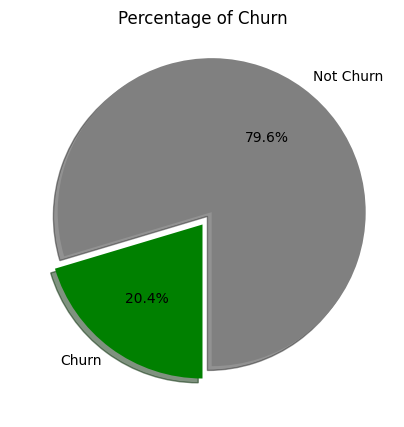

In [8]:
# Pie chart to visualize churn vs non-churn distribution
sizes = df['Exited'].value_counts(sort = True)
colors = ["grey","green"]
mpl.rcParams['figure.figsize'] = 5,5
labels = "Not Churn","Churn"
explode = (0.1,0)
# Pie Chart
plt.pie(sizes,
        explode=explode,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=270,)
plt.title('Percentage of Churn')
plt.show()

**Identify Missing Value From Dataset​**



In [9]:
# Check for missing values in the dataset
df_missing = df.isna().sum()
print(df_missing)

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


**Data Transform**

In [10]:
# One-hot encode 'Geography' since it's a categorical feature
one_hot_ft = ["Geography"]
df = pd.get_dummies(df, columns=one_hot_ft)

In [11]:
# Convert 'Gender' to numerical (1 for Male, 0 for Female)
gender_condition = [(df["Gender"] == "Male"), (df["Gender"] == "Female")]
gender = [1, 0]
df["gender"] = np.select(gender_condition, gender)

# Drop the original 'Gender' column
df = df.drop(columns=["Gender"])
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,gender
0,619,42,2,0.00,1,1,1,101348.88,1,True,False,False,0
1,608,41,1,83807.86,1,0,1,112542.58,0,False,False,True,0
2,502,42,8,159660.80,3,1,0,113931.57,1,True,False,False,0
3,699,39,1,0.00,2,0,0,93826.63,0,True,False,False,0
4,850,43,2,125510.82,1,1,1,79084.10,0,False,False,True,0


**Check Whether Data is Sufficient or Not​**

In [12]:
# Check if the dataset has enough samples relative to the number of predictors (heuristic: 10 samples per predictor)
num_samples = df.shape[0]
num_predictors = df.shape[1] - 1
class_distribution = df['Exited'].value_counts()

In [13]:
if num_samples < 10 * num_predictors:
    print("The number of samples is low. Consider collecting more data.")

# Check for class imbalance (rule of thumb: imbalance if one class is less than 5% of the other)
if len(class_distribution) == 2 and min(class_distribution) / max(class_distribution) < 0.05:
    print("The dataset has a severe class imbalance. Consider addressing class imbalance techniques, such as resampling or using different evaluation metrics.")

In [14]:
# Reconfirm no missing values
missing_values = df.isna().sum()
print(missing_values)

CreditScore          0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Geography_France     0
Geography_Germany    0
Geography_Spain      0
gender               0
dtype: int64


**Check Whether Data is Imbalance or Not​**

In [15]:
# Another check for class imbalance (binary classification)
class_distribution = df['Exited'].value_counts()

In [16]:
if len(class_distribution) == 2:
    # For binary classification
    positive_class_count = class_distribution[1]
    negative_class_count = class_distribution[0]

    if positive_class_count / negative_class_count < 0.05 or negative_class_count / positive_class_count < 0.05:
        print("The dataset has a severe class imbalance.")
    else:
        print("The dataset is not severely imbalanced.")
else:
    # For multi-class classification
    # You can inspect the class distribution or calculate imbalanced metrics
    # depending on your specific problem.
    print("Multi-class classification. Inspect the class distribution or use imbalanced metrics.")


The dataset is not severely imbalanced.


**Split Data into Training and Testing​**

In [17]:
#define independent columns and target (dependent) column
x_col = df.loc[:, df.columns != 'Exited']
y_col = df.loc[:, df.columns == 'Exited']
print(x_col)

      CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0             619   42       2       0.00              1          1   
1             608   41       1   83807.86              1          0   
2             502   42       8  159660.80              3          1   
3             699   39       1       0.00              2          0   
4             850   43       2  125510.82              1          1   
...           ...  ...     ...        ...            ...        ...   
9995          771   39       5       0.00              2          1   
9996          516   35      10   57369.61              1          1   
9997          709   36       7       0.00              1          0   
9998          772   42       3   75075.31              2          1   
9999          792   28       4  130142.79              1          1   

      IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany  \
0                  1        101348.88              True              

In [18]:
#Split dataset into train and test dataset
#using ratio 30% for test dataset and 70% for training dataset
x_train, x_test, y_train, y_test = train_test_split(x_col,
                                                    y_col,
                                                    test_size=0.3,
                                                    random_state=2)

In [19]:
# Train a Logistic Regression model
from sklearn.linear_model import LogisticRegression
churn_model = LogisticRegression()
churn_model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [20]:
# Make predictions on the test set
pred = churn_model.predict(x_test)

**Deploy and Evaluating the Model​**

In [21]:
# Evaluate the model's accuracy
import sklearn.metrics as sm
accuracy = sm.accuracy_score(y_test, pred)
accuracy

0.7943333333333333

In [22]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix as cm
conf = cm(y_test, pred)

# Convert confusion matrix to a DataFrame for easier readability
df_confMatrix = pd.DataFrame(conf, columns=['predicted_not_churn', 'predicted_churn'], index=['not_churn', 'churn'])
print(df_confMatrix)

           predicted_not_churn  predicted_churn
not_churn                 2347               68
churn                      549               36


In [23]:
# Print classification report for detailed performance metrics (precision, recall, F1)
from sklearn.metrics import classification_report as cr
print(cr(y_test, pred))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      2415
           1       0.35      0.06      0.10       585

    accuracy                           0.79      3000
   macro avg       0.58      0.52      0.49      3000
weighted avg       0.72      0.79      0.73      3000



**Visualize Confusion Matrix using Heatmap​**

In [24]:
# Replace 'y_true' with your true labels and 'y_pred' with your predicted labels
conf_matrix = confusion_matrix(y_test, pred)

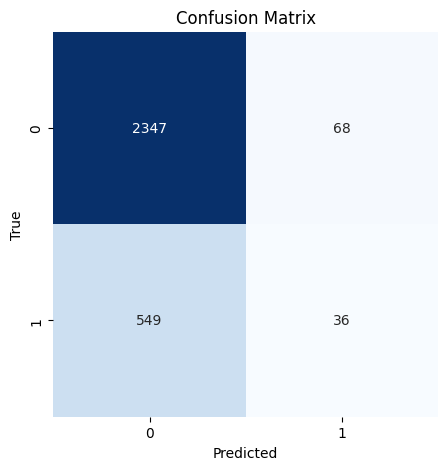

In [25]:
# Create a Seaborn heatmap for the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Perform ROC Curve​**

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [27]:
# Get predicted probabilities for the positive class
y_probs = churn_model.predict_proba(x_test)[:, 1]

In [28]:
#Calculate the ROC curve and AUC (Area Under the Curve):

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

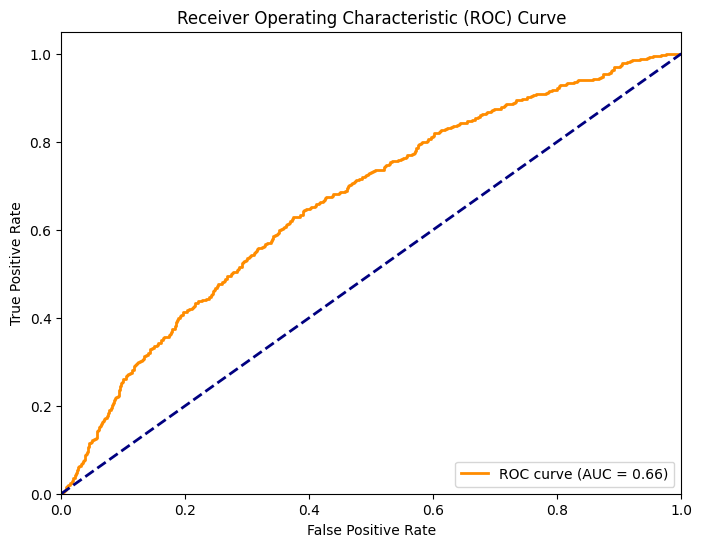

In [29]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()